# Setup

 
Assume that the survey data is exactly what we need.

1) Test using thresholds from the **online** data set

2) Train using the 2nd set of tests of 'user' in the **csv** data set (we found that the 2nd set of tests yielded us better results)

3) Test using other (3rd) data in the **csv** data set!


In [ ]:
'''
  Find data in /data
'''
# # Load the Drive helper and mount
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math # new
from operator import add
random_seed = 1998
#np.random.seed(0)
import time


# Importing online data

In [ ]:
'''
  Find data in /data/online_data.csv
'''
# data = pd.read_csv("/content/drive/Shared drives/Usable Passwords COMPS/Online Dataset Testing/DSL-StrongPasswordData.csv")
data = data[data.columns[:-3]] # remove return key from data set (if data set is in correct format)
individuals = data["subject"].unique() # NumPy: returns the sorted unique elements
# individuals = array of user ids ('unique' ids), s002 to s057
# array(['s002', 's003', 's004', 's005', 's007', 's008', 's010', 's011',
#        's012', 's013', 's015', 's016', 's017', 's018', 's019', 's020',
#        's021', 's022', 's024', 's025', 's026', 's027', 's028', 's029',
#        's030', 's031', 's032', 's033', 's034', 's035', 's036', 's037',
#        's038', 's039', 's040', 's041', 's042', 's043', 's044', 's046',
#        's047', 's048', 's049', 's050', 's051', 's052', 's053', 's054',
#        's055', 's056', 's057'], dtype=object)

columns_to_drop = [i for i in data.columns if "DD." in i] # remove down-down columns
columns_to_keep = data.columns.drop(columns_to_drop)
data = data[columns_to_keep]
individuals = data["subject"].unique()

In [ ]:
'''
  Extract data we use to figure out the mean and stdev.
  (depends on seed and num_samples/ repetitions)
'''
def get_random_samples(df, user, session, num_samples = 10):
  usable_rows = (df["subject"] == user) & (df["sessionIndex"] == session)
  df = df[usable_rows]
  global random_seed 
  df = df.sample(frac=1, random_state = random_seed)
  df.reset_index(inplace=True, drop=True)
  df = df.loc[:num_samples-1]
  df = df[df.columns[3:]]
  return df

# 1) Testing (z-score)

In [ ]:
'''
  Calculates z-score for individual value and adds all of them up 
  ('averaged' total z-score by /sqrt(k))
'''
def calculate_sample_z_score(sample, avg, stdv):
  total_z_score = 0

  # print("Sample:\n")
  # # print(type(sample))
  # # <class 'pandas.core.series.Series'>
  # print(sample.iloc[4:])

  for i in range(len(sample)):
    total_z_score += abs((sample[i] - avg[i]) / stdv[i])
  return total_z_score

In [ ]:
'''
  Simply updates the confusion matrix:

  The function calls calculate_sample_z_score and checks whether the z-score sum is within the bound. 
  If it is, and the user is the ‘true user’, it increments count for TA. If it is, 
  but the user is NOT the ‘true user’, it increments count for FA. If the z-score sum is larger than the bound, 
  then it increments count for TR/FR. The function does this for all sets in the dataset (samples).
'''
def update_confusion_matrix(confusion_matrix, avg, stdv, bound, samples, true_user):
  for i in samples.index:
    z_score = calculate_sample_z_score(samples.loc[i], avg, stdv) / math.sqrt(len(samples.loc[i]))
    print(z_score)
    if z_score > bound:
      confusion_matrix[true_user+"R"] = confusion_matrix[true_user+"R"] + 1
    else: # z-score sum is within bounds! yay, accept
      confusion_matrix[true_user+"A"] = confusion_matrix[true_user+"A"] + 1
  return confusion_matrix

In [ ]:
'''
  Extracts useful data, and computes the mean and variance for ‘repetitions’ amount of trials:

  First we assume our model/ data follows a normal distribution. 
  We then filter out ‘useful data’, which are sets that correspond to a specific user 
  and a session (random <- 1 to 9). We call these sets usable rows. From the usable rows, 
  we get a random sample, but notice that frac = 1, we aren’t really taking a ‘portion’ of usable rows. 
  Instead, we are trying to randomize the row order. Next, we finally get a ‘repetitions’ amount 
  of trials from usable rows. We calculate and mean and stdev, and return these values. 

'''
def get_probability_trained_bound(df, user, session, repetitions = 10):
  # right now, we are assuming it's a normal distribution
  usable_rows = (df["subject"] == user) & (df["sessionIndex"] == session) # filter 1 user, 1 session
  df = df[usable_rows] # usable = chosen user and session
  global random_seed 
  # return df.size (1100)
  df = df.sample(frac=1, random_state = random_seed) # pandas: return a random sample, where frac = fraction of axis items to return
  # return df.size (1100)??? <Q> why sample? -> randomizes rows
  df.reset_index(inplace=True, drop=True) # resets index 
  df = df.loc[:repetitions-1] # get only 'repetitions' amount of rows
  df = df[df.columns[3:]] # remove subject, sessionIndex, rep

  average_row = {}
  stdv = {}
  for i in df.columns:
    average_row[i] = df[i].mean()
    stdv[i] = df[i].std()
  df = df.append(average_row, ignore_index=True)
  df = df.append(stdv, ignore_index=True)

  probability_trained_bound = df.loc[repetitions:] # mean, stdev
  probability_trained_bound = probability_trained_bound.rename(index={repetitions:"avg", repetitions+1:"stdv"})
  return probability_trained_bound

In [ ]:
'''
  Returns a ‘fully calculated’ confusion matrix (for one user), 
  where each element in the list (list <- FA/FR/TA/TR) corresponds to a count of samples within a bound:
 
  We finally get to use bounds here. For each bound, we compute the mean and stdev 
  (bound not needed. Use function ‘get_probability_trained_bound’).
'''
def test_probability_trained_bound(df, user, bounds_to_test, repetitions_train = 10, repetitions_test = 50):
  confusion_matrix_progression = {"TA":[], "TR":[], "FA":[], "FR":[]}
  
  for bound in bounds_to_test:
    print(bound)
    confusion_matrix = {"TA":0, "TR":0, "FA":0, "FR":0}
    np.random.seed(0) 
    training_session = np.random.randint(1, 9)
    start = time.time()
    avg_stdv = get_probability_trained_bound(df, user, training_session, repetitions_train)
    end = time.time()
    print(end - start)
    trained_average = avg_stdv.loc["avg"]
    trained_stdv = avg_stdv.loc["stdv"]

    for session in range(1, 9):
      if session == training_session:
        continue
      random_sample = get_random_samples(df, user, session, repetitions_test)
      confusion_matrix = update_confusion_matrix(confusion_matrix, trained_average, trained_stdv, bound, random_sample, "T")
      
    for test_user in df["subject"].unique():
      if test_user == user:
        continue
      for session in range(1, 9):
        random_sample = get_random_samples(df, test_user, session, repetitions_test)
        confusion_matrix = update_confusion_matrix(confusion_matrix, trained_average, trained_stdv, bound, random_sample, "F")
    
    for key in confusion_matrix_progression.keys():
      confusion_matrix_progression[key].append(confusion_matrix[key])

  return confusion_matrix_progression

In [ ]:
'''
  Loops over all users and sums up all confusion matrices (creates individual plots as well)!
'''
bounds = np.linspace(0, 10, 11) # return evenly spaced numbers over a specified interval, so 10 evenly spaced samples from 0 to 10
  # array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
  #         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

total_cm = {}

for user_i in range(0,len(individuals)):
  confusion_matrix_progression_probability = test_probability_trained_bound(data, individuals[user_i], bounds, 10, 50) 
  # plt.plot(np.array(confusion_matrix_progression_probability['FA']) / (confusion_matrix_progression_probability['FA'][0] + confusion_matrix_progression_probability['FR'][0]))
  # plt.plot(np.array(confusion_matrix_progression_probability['TA']) / (confusion_matrix_progression_probability['TA'][0] + confusion_matrix_progression_probability['TR'][0]))
  # plt.show()

  print('user cm: ', confusion_matrix_progression_probability)
  # print('total cm: ', total_cm)
  if len(total_cm) == 0:
    total_cm = confusion_matrix_progression_probability
  else:
    for rate in confusion_matrix_progression_probability:
      added_prob = list(map(add, total_cm[rate], confusion_matrix_progression_probability[rate]))
      total_cm[rate] = added_prob

    # 'steeper' slop -> FA < TA, and we want to optimize this
    plt.plot(np.array(confusion_matrix_progression_probability['FA']) / (confusion_matrix_progression_probability['FA'][0] + confusion_matrix_progression_probability['FR'][0]), np.array(confusion_matrix_progression_probability['TA']) / (confusion_matrix_progression_probability['TA'][0] + confusion_matrix_progression_probability['TR'][0]))
    plt.plot(np.linspace(0, 1, 2), np.linspace(1, 0, 2), color = "black")
    plt.xlabel("FAR")
    plt.ylabel("TAR")
    plt.title(individuals[user_i])
    plt.show()


avg cm:  {'TA': [0.0, 0.0, 0.3333333333333333, 15.882352941176471, 79.45098039215686, 157.84313725490196, 219.0, 259.52941176470586, 285.7450980392157, 302.88235294117646, 313.3921568627451], 'TR': [350.0, 350.0, 349.6666666666667, 334.11764705882354, 270.54901960784315, 192.15686274509804, 131.0, 90.47058823529412, 64.25490196078431, 47.11764705882353, 36.6078431372549], 'FA': [0.0, 0.0, 0.0392156862745098, 5.098039215686274, 109.56862745098039, 532.1764705882352, 1398.6078431372548, 2672.294117647059, 4215.725490196079, 5891.764705882353, 7573.254901960784], 'FR': [20000.0, 20000.0, 19999.960784313724, 19994.901960784315, 19890.43137254902, 19467.823529411766, 18601.392156862745, 17327.70588235294, 15784.274509803921, 14108.235294117647, 12426.745098039215]}


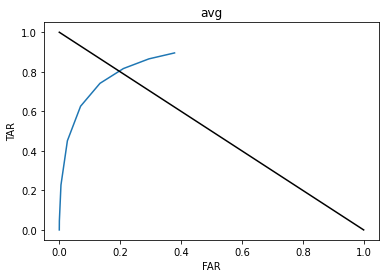

8
8.0


In [ ]:
avg_cm = {}
# this step is intuitively reasonable, but unnecessary in this case
# since total_cm already sums up rates and is therefore ~ average.
for rate in total_cm:
  avg_prob = list(map(lambda x: x/len(individuals), total_cm[rate]))
  avg_cm[rate] = avg_prob
print('avg cm: ', avg_cm)

plt.plot(np.array(avg_cm['FA']) / (avg_cm['FA'][0] + avg_cm['FR'][0]),
        np.array(avg_cm['TA']) / (avg_cm['TA'][0] + avg_cm['TR'][0]))
plt.plot(np.linspace(0, 1, 2), np.linspace(1, 0, 2), color = "black")
plt.title("avg")
plt.xlabel("FAR")
plt.ylabel("TAR")
plt.show()

TAR_progression = np.array(avg_cm['TA']) / (avg_cm['TA'][0] + avg_cm['TR'][0])
FAR_progression = np.array(avg_cm['FA']) / (avg_cm['FA'][0] + avg_cm['FR'][0])

best_index = np.argmin(abs(1 - (TAR_progression + FAR_progression))) # which bound gives us a rate sum close to 1?
best_bound = bounds[best_index]
print(best_index)
print(best_bound)

# the best bound from the online data set = 8

# 2) and 3) Testing with survey data

In [ ]:
'''
  Find data in /data/survey_data_csv.csv
'''
# survey_data = pd.read_csv("/content/drive/Shared drives/Usable Passwords COMPS/SurveyData/Survey_A.csv")

In [ ]:
'''
  Same as the one in the previous section --
  just needed a new one to index sample.
'''
def calculate_sample_z_score_survey(sample, avg, stdv):
  total_z_score = 0
  sample = sample.iloc[4:] # the survey data sample has other columns (subject and stuff)
  # print("Sample:\n")
  # print(type(sample))
  # <class 'pandas.core.series.Series'>
  # print(sample.iloc[4:])
  # print(sample)

  for i in range(len(sample)):
    total_z_score += abs((sample[i] - avg[i]) / stdv[i])
  return total_z_score

In [ ]:
'''
  Same as the one in the previous section --
  changed the z-score function so that function call
  had to be different (lazy move).
'''
def update_confusion_matrix_survey(confusion_matrix, avg, stdv, bound, samples, true_user):
  for i in samples.index:
    z_score = calculate_sample_z_score_survey(samples.loc[i], avg, stdv) / math.sqrt(len(samples.loc[i]))
    if z_score > bound:
      confusion_matrix[true_user+"R"] = confusion_matrix[true_user+"R"] + 1
    else: # z-score sum is within bounds! yay, accept
      confusion_matrix[true_user+"A"] = confusion_matrix[true_user+"A"] + 1
  return confusion_matrix

In [ ]:
'''
  We just set ‘repetitions = 10’. That's the only difference.
'''
def get_probability_trained_bound_survey(df, user, session):
  usable_rows = (df["subject"] == user) & (df["sessionIndex"] == session) # filter 1 user, 1 session
  df = df[usable_rows] # usable = chosen user and session
  
  global random_seed 
 
  #pandas: return a random sample, where frac = fraction of axis items to return
  #df = df.sample(frac=1, random_state = random_seed) 

  df.reset_index(inplace=True, drop=True) # resets index 
  df = df[df.columns[3:]] # remove subject, sessionIndex, rep

  average_row = {}
  stdv = {}
  for i in df.columns:
    average_row[i] = df[i].mean()
    stdv[i] = df[i].std()
  df = df.append(average_row, ignore_index=True)
  df = df.append(stdv, ignore_index=True)

  probability_trained_bound = df.loc[10:] # mean, stdev
  probability_trained_bound = probability_trained_bound.rename(index={10:"avg", 11:"stdv"})
  return probability_trained_bound

In [ ]:
'''
  For the survey data, we are using only one bound (optimal ‘z-score-sum-bounds’, which was 8), 
  so we don’t have to loop over all bounds. We also don’t have to randomly 
  select a session since we decided to train on session 2. 
'''
def test_probability_trained_bound_survey(df, user, bound, session_train):
  
  confusion_matrix = {"TA":0, "TR":0, "FA":0, "FR":0}
  start = time.time()
  avg_stdv = get_probability_trained_bound(df, user, session_train)
  end = time.time()
  print(end-start)
  trained_avg = avg_stdv.loc["avg"]
  trained_stdv = avg_stdv.loc["stdv"]

  # 1) TRUE: test 9 sessions data against mean/ stdev calculations
  # we are trying to identify a 'user' (testing for one user's sessions)
  usable_rows = (df["subject"] == user) & (df["sessionIndex"] == 3) # filter 1 user, 1 session
  test_sample = df[usable_rows] # usable = chosen user and session
  test_sample.reset_index(inplace = True)
  confusion_matrix = update_confusion_matrix_survey(confusion_matrix, trained_avg, trained_stdv, bound, test_sample, "T")

  # 2) FALSE: not user
  non_user_rows =  (df["subject"] != user)
  test_sample = df[non_user_rows]
  test_sample.reset_index(inplace = True)
  confusion_matrix = update_confusion_matrix_survey(confusion_matrix, trained_avg, trained_stdv, bound, test_sample, "F")

  #print(confusion_matrix)
  return confusion_matrix

In [ ]:
TAR_list = []
FAR_list = []
# total_cm = {}
for users in survey_data["subject"].unique():
  #check if user has 30 inputs
  if(survey_data["subject"]==users).sum() != 30:
    continue
  confusion_matrix = test_probability_trained_bound_survey(survey_data, user = users, bound=8, session_train = 2)
  TAR = confusion_matrix['TA']/(confusion_matrix['TA'] + confusion_matrix['TR'])
  FAR = confusion_matrix['FA']/(confusion_matrix['FA'] + confusion_matrix['FR'])
  TAR_list.append(TAR)
  FAR_list.append(FAR)

print(np.array(TAR_list).min())
print(np.array(FAR_list).max())
print("")
print(np.array(TAR_list).mean()) # that's pretty good:)
print(np.array(FAR_list).mean())